# Impact of Modified Gravity $c_s^2$ on observables

In this Notebook, I test the impact of the MG-cs2 model on the cosmological observables.

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import camb

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["legend.framealpha"] = 0.0

In [ ]:
# Cosmological parameters for examples
H0 = 67
omegam = 0.319
omegab = 0.049
As = 2.1e-9
ns = 0.96
tau = 0.07

dark_energy_types = ["desi_pp_mean", "wcdm"]
dark_energy_type = "desi_pp_mean"

if dark_energy_type == "desi_pp_mean":
    # DESI DR2 BAO + CMB + Pantheon+ mean
    w0 = -0.838
    wa = -0.62
elif dark_energy_type == "wcdm":
    w0 = -0.8
    wa = 0
else:
    raise Exception(f"Unsupported dark_energy_type {dark_energy_type}; supported values are {dark_energy_types}.")

# Derived parameters
h = H0/100
omegac = omegam - omegab
ombh2 = omegab*h*h
omch2 = omegac*h*h

# k, z grid for power spectrum
ks = np.logspace(-4, -0.9, 256)
redshifts = np.linspace(0, 3, 256)

In [27]:
cases = [
    {"name": "GR",    "label": "GR",            "use_cs2": False, "cs2_0": 1 },
    {"name": "light", "label": "$c_s^2 = 0.5$", "use_cs2": True,  "cs2_0": 0.5 },
    {"name": "light", "label": "$c_s^2 = 1$",   "use_cs2": True,  "cs2_0": 1 },
    {"name": "super", "label": "$c_s^2 = 2$",   "use_cs2": True,  "cs2_0": 2 },
    # {"name": "sub",   "label": "$c_s^2 = 10^{-1}$", "use_cs2": True,  "cs2_0": 0. },
]

def get_observables(case):
    cosmo = camb.set_params(
        H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau,
        num_nu_massless=3.044, omnuh2=0, WantTransfer=True, w=w0, wa=wa,
        dark_energy_model="fluid" if dark_energy_type == "wcdm" else "ppf",
        use_cs2=case["use_cs2"], alpha_K_parametrization=1, cs2_0=case["cs2_0"], alpha_K_0=1
    )
    cosmo.set_for_lmax(2000, lens_potential_accuracy=1)
    cosmo.set_matter_power(redshifts=redshifts, kmax=20, silent=True, nonlinear=None)
    results = camb.get_results(cosmo)
    P_lin = results.get_matter_power_interpolator(nonlinear=None).P(redshifts, ks)
    cl_tt = results.get_lensed_scalar_cls(CMB_unit='muK')[:,0]
    cl_ee = results.get_lensed_scalar_cls(CMB_unit='muK')[:,1]
    cl_te = results.get_lensed_scalar_cls(CMB_unit='muK')[:,3]
    cl_pp = results.get_lens_potential_cls(lmax=2000)[:,0]
    log_a = results.Params.log_a
    mu = results.Params.mu
    return {"P_lin": P_lin, "cl_tt": cl_tt, "cl_ee": cl_ee, "cl_te": cl_te, "cl_pp": cl_pp, "log_a": log_a, "mu": mu}

data = {}
for case in cases:
    data[case["name"]] = get_observables(case)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_71567/1665711206.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


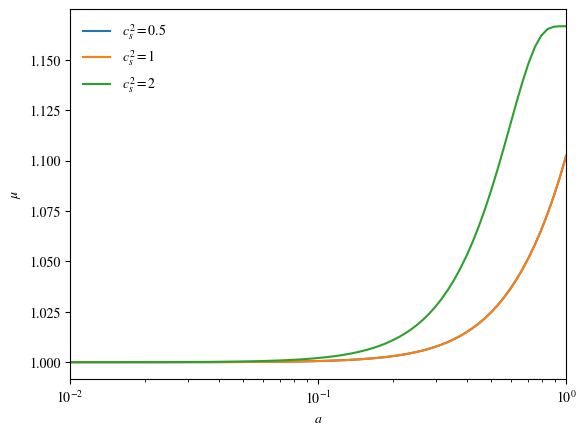

In [37]:
# Plot \mu(a)
for case in cases[1:]:
    a = np.exp(d["log_a"])
    d = data[case["name"]]
    plt.semilogx(a, d["mu"], label=case["label"])
plt.xlabel("$a$")
plt.ylabel("$\mu$")
plt.xlim([1e-2, 1])
plt.legend()

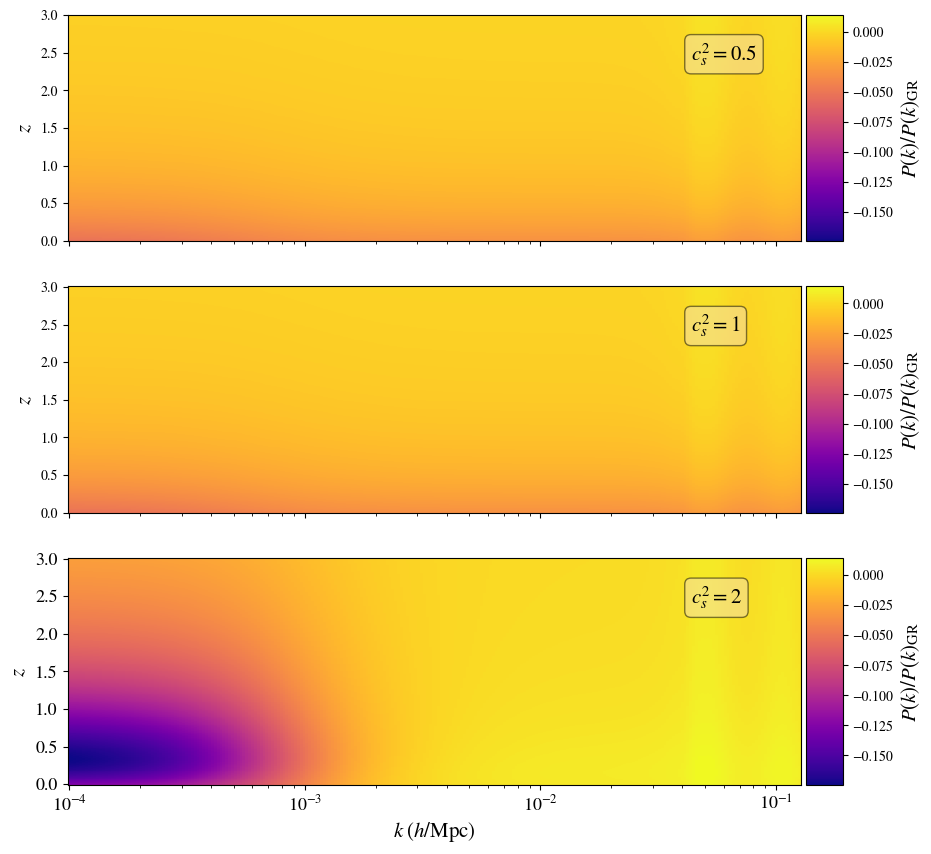

In [38]:
# Plot P(k)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

# Precomputing min and max relative errors for unifying the colormaps in each axis
fig, axs = plt.subplots(len(cases)-1, 1, sharex=True, sharey=True, figsize=(10, 10))
vmin = np.inf
vmax = -np.inf
for ax, case in zip(axs, cases[1:]):
    relative_errors = data[case["name"]]["P_lin"]/data["GR"]["P_lin"] - 1
    vmin = min(vmin, np.amin(relative_errors))
    vmax = max(vmax, np.amax(relative_errors))
norm = Normalize(vmin=vmin, vmax=vmax)

for ax, case in zip(axs, cases[1:]):
    relative_errors = data[case["name"]]["P_lin"]/data["GR"]["P_lin"] - 1
    mesh = ax.pcolormesh(ks, redshifts, relative_errors, cmap="plasma", norm=norm)
    ax.set_xscale('log')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(mesh, cax=cax, orientation="vertical")
    cax.set_ylabel(r"$P(k)/P(k)_\mathrm{GR}$", fontsize=15)
    ax.set_ylabel(r"$z$", fontsize=15)
    ax.text(0.85, 0.8, case["label"], transform=ax.transAxes, bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5}, fontsize=15)

axs[-1].tick_params(labelsize=13)
axs[-1].set_xlabel(r"$k \; (h/\mathrm{Mpc})$", fontsize=15)
plt.savefig("plots/cs2_impact_pk_mg.png", bbox_inches="tight")

/tmp/ipykernel_71567/3612381828.py:7: RuntimeWarning: invalid value encountered in divide
  axs[0].semilogx(ells_tt, data[case["name"]]["cl_tt"]/data["GR"]["cl_tt"] - 1, label=case["label"])
/tmp/ipykernel_71567/3612381828.py:8: RuntimeWarning: invalid value encountered in divide
  axs[1].semilogx(ells_pp, data[case["name"]]["cl_pp"]/data["GR"]["cl_pp"] - 1, label=case["label"])
/tmp/ipykernel_71567/3612381828.py:9: RuntimeWarning: invalid value encountered in divide
  axs[2].semilogx(ells_tt, data[case["name"]]["cl_ee"]/data["GR"]["cl_ee"] - 1, label=case["label"])


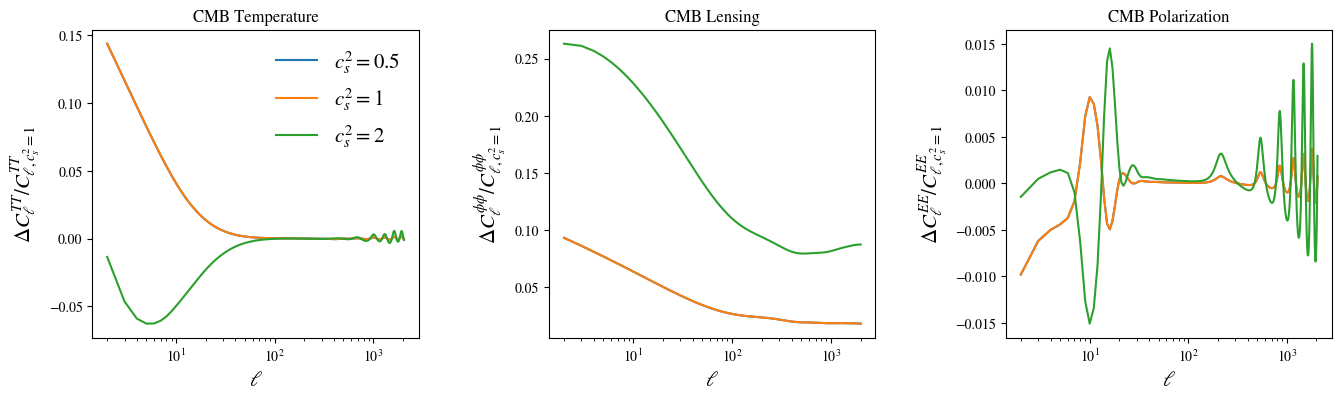

In [39]:
# Plot CMB
fig, axs = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'wspace': 0.4})
ells_tt = np.arange(2051)
ells_pp = np.arange(2001)
for case in cases:
    if case["name"] == "GR": continue
    axs[0].semilogx(ells_tt, data[case["name"]]["cl_tt"]/data["GR"]["cl_tt"] - 1, label=case["label"])
    axs[1].semilogx(ells_pp, data[case["name"]]["cl_pp"]/data["GR"]["cl_pp"] - 1, label=case["label"])
    axs[2].semilogx(ells_tt, data[case["name"]]["cl_ee"]/data["GR"]["cl_ee"] - 1, label=case["label"])
    # axs[1,1].semilogx(ells_tt, data[case["name"]]["cl_te"]/data["GR"]["cl_te"] - 1, label=case["label"])
    # NOTE: TE has negligible variations

axs[0].set_title("CMB Temperature")
axs[0].set_xlabel(r"$\ell$", fontsize=15)
axs[0].set_ylabel(r"$\Delta C_\ell^{TT}/C_{\ell, c_s^2=1}^{TT}$", fontsize=15)
axs[1].set_title("CMB Lensing")
axs[1].set_xlabel(r"$\ell$", fontsize=15)
axs[1].set_ylabel(r"$\Delta C_\ell^{\phi\phi}/C_{\ell, c_s^2=1}^{\phi\phi}$", fontsize=15)
axs[2].set_title("CMB Polarization")
axs[2].set_xlabel(r"$\ell$", fontsize=15)
axs[2].set_ylabel(r"$\Delta C_\ell^{EE}/C_{\ell, c_s^2=1}^{EE}$", fontsize=15)
axs[0].legend(fontsize=15)
plt.savefig("plots/cs2_impact_cmb_mg.pdf", bbox_inches="tight")